In [1]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/hem-3-folder/dataset/validation/no/aug_82_4270.png
/kaggle/input/hem-3-folder/dataset/validation/no/aug_46_3843.png
/kaggle/input/hem-3-folder/dataset/validation/no/173.png
/kaggle/input/hem-3-folder/dataset/validation/no/aug_0_6383.png
/kaggle/input/hem-3-folder/dataset/validation/no/aug_46_4961.png
/kaggle/input/hem-3-folder/dataset/validation/no/aug_61_630.png
/kaggle/input/hem-3-folder/dataset/validation/no/aug_40_2606.png
/kaggle/input/hem-3-folder/dataset/validation/no/aug_96_2781.png
/kaggle/input/hem-3-folder/dataset/validation/no/aug_29_4856.png
/kaggle/input/hem-3-folder/dataset/validation/no/aug_41_4007.png
/kaggle/input/hem-3-folder/dataset/validation/no/aug_27_152.png
/kaggle/input/hem-3-folder/dataset/validation/no/aug_98_2145.png
/kaggle/input/hem-3-folder/dataset/validation/no/aug_1_5807.png
/kaggle/input/hem-3-folder/dataset/validation/no/aug_13_4833.png
/kaggle/input/hem-3-folder/dataset/validation/no/162.png
/kaggle/input/hem-3-folder/dataset/validation

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import os
import cv2
import shutil
import itertools

import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras.models import Model, Sequential
from keras.layers import TimeDistributed, Dense, Flatten, Dropout, Bidirectional, LSTM, GRU
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras_preprocessing.image import ImageDataGenerator

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

#init_notebook_mode(connected=True)
RANDOM_SEED = 42

In [3]:
train_dir = "../input/hem-3-folder/dataset/train/"
validation_dir = "../input/hem-3-folder/dataset/validation/"
test_dir = "../input/hem-3-folder/dataset/test/"

In [4]:
def load_data(dir_path):
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels

In [5]:
X_train, y_train, labels = load_data(train_dir)
X_test, y_test, _ = load_data(test_dir)
X_val, y_val, _ = load_data(validation_dir)

100%|██████████| 2/2 [00:13<00:00,  6.81s/it]


1536 images loaded from ../input/hem-3-folder/dataset/train/ directory.


100%|██████████| 2/2 [00:04<00:00,  2.02s/it]


480 images loaded from ../input/hem-3-folder/dataset/test/ directory.


100%|██████████| 2/2 [00:03<00:00,  1.64s/it]

384 images loaded from ../input/hem-3-folder/dataset/validation/ directory.


In [6]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(1536, 227, 227, 3)
(480, 227, 227, 3)
(384, 227, 227, 3)


In [7]:
X_train = np.array([cv2.resize(image, (224, 224)) for image in X_train])
X_test = np.array([cv2.resize(image, (224, 224)) for image in X_test])
X_val = np.array([cv2.resize(image, (224, 224)) for image in X_val])

In [8]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(1536, 224, 224, 3)
(480, 224, 224, 3)
(384, 224, 224, 3)


In [9]:
input_shape = (224,224, 3)
batch_size = 32

In [10]:
training_datagen = ImageDataGenerator(rescale = 1./255)
validation_datagen = ImageDataGenerator(rescale = 1./255)

In [11]:
train_generator = training_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)

val_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 1536 images belonging to 2 classes.
Found 384 images belonging to 2 classes.


In [12]:
model = tf.keras.Sequential([
    
    tf.keras.layers.Conv2D(32,(3,3),activation='relu',input_shape=(224,224,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.40),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.40),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.40),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

2021-11-17 15:58:38.807761: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-17 15:58:38.916828: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-17 15:58:38.917639: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 64)        3

2021-11-17 15:58:38.919549: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-17 15:58:38.920317: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-17 15:58:38.921121: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-17 15:58:38.921850: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [13]:
model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [14]:
EPOCHS = 200
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.1,
    patience=3,
    min_lr=1e-6,
    verbose=1)

es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max',
    patience=6
)
filename = 'custom5layer.h5'
check_pt = ModelCheckpoint(
    filename,
    monitor="val_accuracy",
    verbose=1,
    save_best_only=True
)

history = model.fit(train_generator, epochs=EPOCHS, batch_size=16, validation_data=val_generator, callbacks=[reduce_lr, es, check_pt])


2021-11-17 15:58:41.593534: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200


2021-11-17 15:58:43.486575: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


48/48 [==============================] - 14s 140ms/step - loss: 0.6881 - accuracy: 0.5163 - val_loss: 0.6711 - val_accuracy: 0.5130

Epoch 00001: val_accuracy improved from -inf to 0.51302, saving model to custom5layer.h5
Epoch 2/200
48/48 [==============================] - 6s 132ms/step - loss: 0.6478 - accuracy: 0.6152 - val_loss: 0.5631 - val_accuracy: 0.7552

Epoch 00002: val_accuracy improved from 0.51302 to 0.75521, saving model to custom5layer.h5
Epoch 3/200
48/48 [==============================] - 7s 145ms/step - loss: 0.5635 - accuracy: 0.7096 - val_loss: 0.4865 - val_accuracy: 0.7995

Epoch 00003: val_accuracy improved from 0.75521 to 0.79948, saving model to custom5layer.h5
Epoch 4/200
48/48 [==============================] - 6s 135ms/step - loss: 0.5187 - accuracy: 0.7546 - val_loss: 0.4632 - val_accuracy: 0.8151

Epoch 00004: val_accuracy improved from 0.79948 to 0.81510, saving model to custom5layer.h5
Epoch 5/200
48/48 [==============================] - 6s 129ms/step - l

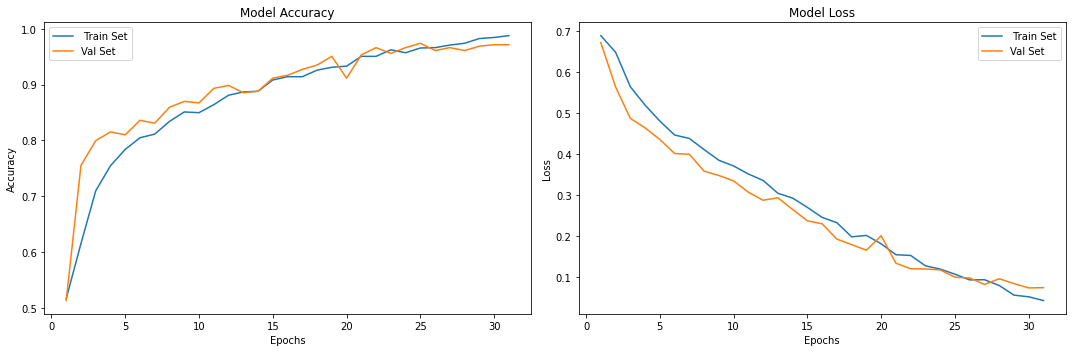

In [15]:
epochs_range = range(1, len(history.epoch) + 1)
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, history.history["accuracy"], label=' Train Set')
plt.plot(epochs_range, history.history["val_accuracy"], label='Val Set')
plt.xlabel('Epochs')
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history.history["loss"], label=' Train Set')
plt.plot(epochs_range, history.history["val_loss"], label='Val Set')
plt.xlabel('Epochs')
plt.ylabel("Loss")
plt.legend(loc="best")
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [16]:
from tensorflow.keras.models import load_model
saved_model = load_model('./custom5layer.h5')

In [17]:
# validate on test set
predictions = model.predict(X_val)
predictions = [1 if x>0.5 else 0 for x in predictions]

_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, val_acc = model.evaluate(X_val, y_val, verbose=0)

print('Train: %.4f, Val: %.4f' % (train_acc, val_acc))

accuracy = accuracy_score(y_val, predictions)
print('Validation Accuracy = %.4f' % accuracy)

# precision: tp / (tp + fp)
precision = precision_score(y_val, predictions)
print('Precision: %f' % precision)

  # recall: tp / (tp + fn)
recall = recall_score(y_val, predictions)
print('Recall: %f' % recall)

  # f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_val, predictions)
print('F1 score: %f' % f1)

#KAPPA SCORE
kappa = cohen_kappa_score(y_val, predictions)
print('Cohens kappa: %f' % kappa)

  # ROC AUC
auc = roc_auc_score(y_val, predictions)
print('ROC AUC: %f' % auc)
 
# confusion matrix
matrix = confusion_matrix(y_val, predictions)
print(matrix)

tn, fp, fn, tp = matrix.ravel()
print("True positive:", tp, ", True negative:", tn,
            ", False positive:", fp, ", False negative:", fn)

Train: 0.9727, Val: 0.9635
Validation Accuracy = 0.9635
Precision: 0.945000
Recall: 0.984375
F1 score: 0.964286
Cohens kappa: 0.927083
ROC AUC: 0.963542
[[181  11]
 [  3 189]]
True positive: 189 , True negative: 181 , False positive: 11 , False negative: 3


In [18]:
# validate on test set (saved model)
predictions = saved_model.predict(X_test)
predictions = [1 if x>0.5 else 0 for x in predictions]

_, train_acc = saved_model.evaluate(X_train, y_train, verbose=0)
_, test_acc = saved_model.evaluate(X_test, y_test, verbose=0)

print('Train: %.4f, Test: %.4f' % (train_acc, test_acc))

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.4f' % accuracy)

# precision: tp / (tp + fp)
precision = precision_score(y_test, predictions)
print('Precision: %f' % precision)

  # recall: tp / (tp + fn)
recall = recall_score(y_test, predictions)
print('Recall: %f' % recall)

  # f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, predictions)
print('F1 score: %f' % f1)

#KAPPA SCORE
kappa = cohen_kappa_score(y_test, predictions)
print('Cohens kappa: %f' % kappa)

  # ROC AUC
auc = roc_auc_score(y_test, predictions)
print('ROC AUC: %f' % auc)
 
# confusion matrix
matrix = confusion_matrix(y_test, predictions)
print(matrix)

tn, fp, fn, tp = matrix.ravel()
print("True positive:", tp, ", True negative:", tn,
            ", False positive:", fp, ", False negative:", fn)

Train: 0.9772, Test: 0.9667
Test Accuracy = 0.9667
Precision: 0.962810
Recall: 0.970833
F1 score: 0.966805
Cohens kappa: 0.933333
ROC AUC: 0.966667
[[231   9]
 [  7 233]]
True positive: 233 , True negative: 231 , False positive: 9 , False negative: 7


(1, 222, 222, 32)
(1, 111, 111, 32)
(1, 109, 109, 32)
(1, 54, 54, 32)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide


(1, 52, 52, 64)
(1, 26, 26, 64)
(1, 24, 24, 64)
(1, 12, 12, 64)
(1, 10, 10, 128)
(1, 5, 5, 128)
(1, 3200)
(1, 64)
(1, 64)
(1, 128)
(1, 128)
(1, 256)
(1, 256)
(1, 1)


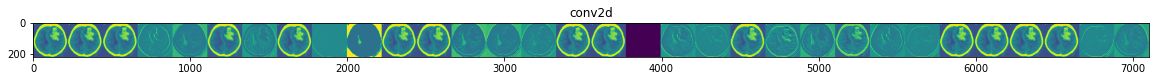

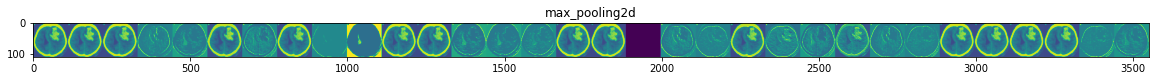

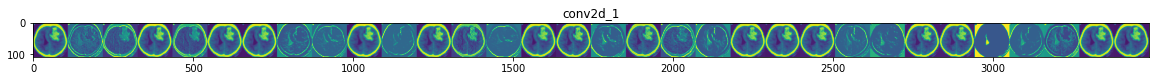

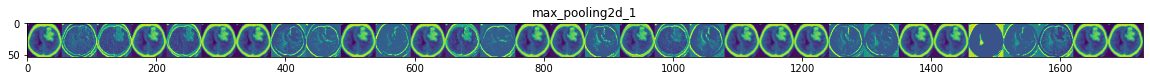

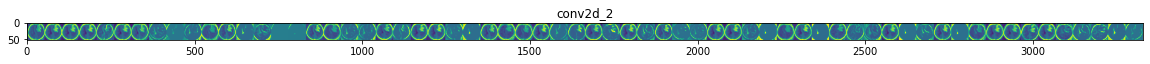

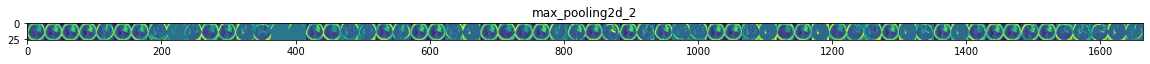

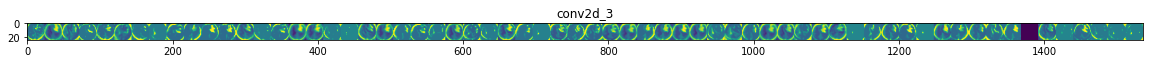

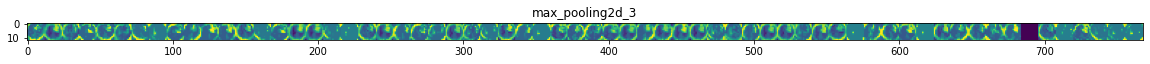

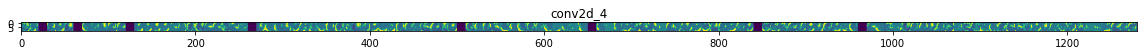

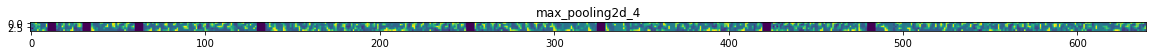

In [21]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
img_path='../input/hem-3-folder/dataset/test/yes/000.png'

successive_outputs = [layer.output for layer in model.layers[0:]]

visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

img = load_img(img_path, target_size=(224, 224))  

x   = img_to_array(img)                           # Numpy array with shape (150, 150, 3)
x   = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255.0

successive_feature_maps = visualization_model.predict(x)

layer_names = [layer.name for layer in model.layers]

for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  print(feature_map.shape)
  if len(feature_map.shape) == 4:
        
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    display_grid = np.zeros((size, size * n_features))
    
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto')
